In [3]:
import json
import os 
import scipy.io
import random
from sklearn.preprocessing import MinMaxScaler # normalize the x,y coordinates
import networkx as nx # for graph
import matplotlib.pyplot as plt
import numpy as np

Define the nodes for the poses

In [9]:
graph = dict() # initialize graph

points = []
# read the landmarks.m file
with open('landmarks\horse\landmarks.m', 'r') as f:
    for i in f:
        split_result = i.split(' = ')
        if len(split_result) >= 2:
            # print(split_result[1].split(';')[0])
            points.append(split_result[1].split(';')[0].split("'")[1])

# add points to graph
graph['chin'] = ['leftEye', 'rightEye', 'neck']
graph['rightEye'] = ['chin', 'leftEye', 'neck']
graph['leftEye'] = ['chin', 'rightEye', 'neck']
graph['neck'] = ['chin', 'leftEye', 'rightEye', 'leftShoulder', 'rightShoulder']
graph['leftShoulder'] = ['neck', 'frontLeftHip', 'tailStart']
graph['rightShoulder'] = ['neck', 'frontRightHip', 'tailStart']
graph['frontLeftHip'] = ['leftShoulder', 'frontLeftKnee']
graph['frontRightHip'] = ['rightShoulder', 'frontRightKnee']
graph['frontLeftKnee'] = ['frontLeftHip', 'frontLeftHoof']
graph['frontRightKnee'] = ['frontRightHip', 'frontRightHoof']
graph['frontLeftHoof'] = ['frontLeftKnee']
graph['frontRightHoof'] = ['frontRightKnee']
graph['tailStart'] = ['leftShoulder', 'rightShoulder', 'backLeftHip', 'backRightHip']
graph['backLeftHip'] = ['tailStart', 'backLeftKnee']
graph['backRightHip'] = ['tailStart', 'backRightKnee']
graph['backLeftKnee'] = ['backLeftHip', 'backLeftHoof']
graph['backRightKnee'] = ['backRightHip', 'backRightHoof']
graph['backLeftHoof'] = ['backLeftKnee']
graph['backRightHoof'] = ['backRightKnee']

len(graph) == len(points) # check that all points are in graph

True

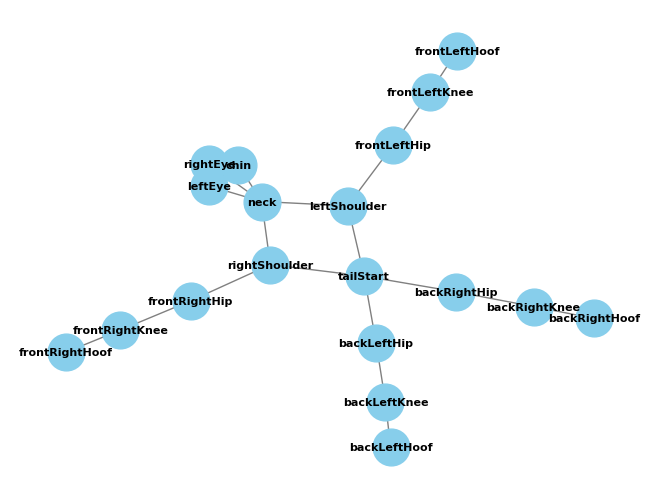

In [11]:
# Create a graph
graph_network = nx.Graph(graph)


# Draw the graph
# pos = nx.spring_layout(graph_network)  # You can choose a different layout algorithm
nx.draw(graph_network, with_labels=True, font_weight='bold', node_size=700, 
        node_color='skyblue', font_color='black', font_size=8, edge_color='gray')

# Display the graph
plt.show()


In [12]:
# save dictionary to JSON file
with open('behavoiur-discovery/graph.json', 'w') as fp:
    json.dump(graph, fp, indent=4)

Define rules to connect the nodes
1. Load the .mat files 
2. Create a graph for each frame and a queue for each file
3. Normalize the x,y coordinates

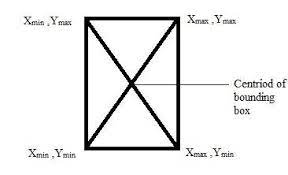

In [ ]:
from generate_graphs import graph_sequence
graph_seq = graph_sequence()

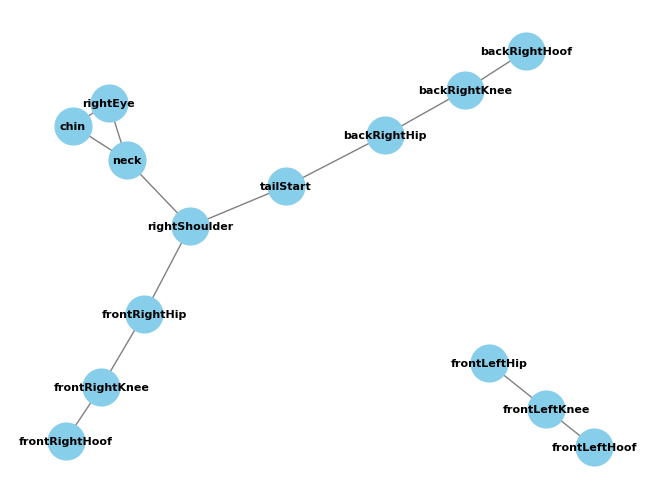

In [4]:
first_file_frame = graph_seq['647.mat'][0]
# draw the graph
# pos = nx.spring_layout(first_file_frame)
nx.draw(first_file_frame,  with_labels=True, font_weight='bold', node_size=700, 
        node_color='skyblue', font_color='black', font_size=8, edge_color='gray')

In [5]:
nx.to_dict_of_lists(first_file_frame)

{'chin': ['rightEye', 'neck'],
 'rightEye': ['chin', 'neck'],
 'neck': ['chin', 'rightEye', 'rightShoulder'],
 'rightShoulder': ['neck', 'frontRightHip', 'tailStart'],
 'frontRightHip': ['rightShoulder', 'frontRightKnee'],
 'tailStart': ['rightShoulder', 'backRightHip'],
 'frontLeftHip': ['frontLeftKnee'],
 'frontLeftKnee': ['frontLeftHip', 'frontLeftHoof'],
 'frontRightKnee': ['frontRightHip', 'frontRightHoof'],
 'frontLeftHoof': ['frontLeftKnee'],
 'frontRightHoof': ['frontRightKnee'],
 'backRightHip': ['tailStart', 'backRightKnee'],
 'backRightKnee': ['backRightHip', 'backRightHoof'],
 'backRightHoof': ['backRightKnee']}

In [329]:
len(list(G.nodes))

16